In [105]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import cplex
import seaborn as sns

In [106]:
# buy and hold strategy

def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
    x_optimal = x_init
    cash_optimal = cash_init
    
    return x_optimal, cash_optimal

In [107]:
# equally weighted strategy

def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    w = np.full(20, 1/20)
    V_init = np.dot(cur_prices, x_init) + cash_init
    x_optimal = np.zeros(20)
    txn_cost = 0
    
    for i in range(20):
        x_optimal[i] = V_init*w[i]/cur_prices[i]
        x_optimal[i] = math.floor(x_optimal[i]) # rounding procedure
        txn_cost += 0.005*cur_prices[i]*abs(x_optimal[i]-x_init[i])
    
    cash_optimal = V_init - np.dot(cur_prices, x_optimal) - txn_cost
    
    return x_optimal, cash_optimal

In [108]:
# minimum variance strategy

def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    V_init = np.dot(cur_prices, x_init) + cash_init
    
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    
    c  = [0.0] * 20
    lb = [0.0] * 20
    ub = [1.0] * 20
    
    A = []
    for k in range(20):
        A.append([[0,1],[1,0]])
    
    var_names = ["w_%s" % i for i in range(1,20+1)]
    
    cpx.linear_constraints.add(rhs=[1.0,0],senses='EG')
    
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    
    Qmat = [[list(range(20)), list(2*Q[k,:])] for k in range(20)]
    
    cpx.objective.set_quadratic(Qmat)
    
    cpx.parameters.threads.set(6)
    
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    
    cpx.solve()
    w = cpx.solution.get_values()
    
    x_optimal = np.zeros(20)
    txn_cost = 0
    
    for i in range(20):
        x_optimal[i] = V_init*w[i]/cur_prices[i]
        x_optimal[i] = math.floor(x_optimal[i]) # rounding procedure
        txn_cost += 0.005*cur_prices[i]*abs(x_optimal[i]-x_init[i])
    
    cash_optimal = V_init - np.dot(cur_prices, x_optimal) - txn_cost
    
    return x_optimal, cash_optimal

In [109]:
# maximum Sharpe ratio strategy

def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    V_init = np.dot(cur_prices, x_init) + cash_init
    
    r_rf = 0.025
    r_rf_daily = 1.025**(1.0/252)-1 #daily risk-free rate

    Q_1 = np.append(Q,np.zeros((20,1)),axis=1)
    Q_1 = np.vstack([Q_1,np.zeros((21))])

    sharpe_diff = mu-r_rf_daily * np.ones(20)

    A = []
    for k in range(20):
        A.append([[0,1],[sharpe_diff[k],1.0]])
    A.append([[0,1],[0,-1.0]])

    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    c = [0]*21
    lb = [0]*21
    ub = [np.inf]*21

    var_names = ['y_%s'% i for i in range(1,21+1)]
    cpx.linear_constraints.add(rhs=[1.0,0],senses='EE')
    cpx.variables.add(obj=c,lb=lb,ub=ub,columns=A,names=var_names)

    Qmat = [[list(range(21)),list(2*Q_1[k,:])] for k in range(21)]

    cpx.objective.set_quadratic(Qmat)
    cpx.parameters.threads.set(6)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()

    w = np.array(cpx.solution.get_values())
    w = w[0:20]/w[20]
    
    x_optimal = np.zeros(20)
    txn_cost = 0
    
    for i in range(20):
        x_optimal[i] = V_init*w[i]/cur_prices[i]
        x_optimal[i] = math.floor(x_optimal[i]) # rounding procedure
        txn_cost += 0.005*cur_prices[i]*abs(x_optimal[i]-x_init[i])
    
    cash_optimal = V_init - np.dot(cur_prices, x_optimal) - txn_cost

    return x_optimal, cash_optimal

In [118]:
# Input file
input_file_prices = 'Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2018 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2018)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2018
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 980, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20000])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2019-2020 is 2.5%
r_rf = 0.025

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio']
#N_strat = 1  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 19:
       cur_year  = 19 + math.floor(period/7)
   else:
       cur_year  = 2019 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      while cash[strategy, period-1] < 0:
            
            V_init = np.dot(cur_prices, curr_positions) + curr_cash
            x_normalized = x[strategy][period-1]/np.sum(x[strategy][period-1])
            cash_extra = abs(cash[strategy][period-1])*x_normalized
            x_extra = np.ceil(cash_extra/cur_prices)
            x[strategy][period-1] = x[strategy][period-1] - x_extra
            txn_cost = 0.005*np.dot(cur_prices, abs(x[strategy][period-1]-curr_positions))
            cash[strategy][period-1] = V_init - np.sum(cur_prices*x[strategy][period-1]) - txn_cost

            
            
      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print()
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)
    



Initial portfolio value = $ 1000070.06


Period 1: start date 01/02/2019, end date 02/28/2019

  Strategy "Buy and Hold", value begin = $ 1000070.06, value end = $ 1121179.83

  Strategy "Equally Weighted Portfolio", value begin = $ 991124.38, value end = $ 1097031.81

  Strategy "Mininum Variance Portfolio", value begin = $ 991702.28, value end = $ 1057440.44

  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990119.39, value end = $ 1016524.41

Period 2: start date 03/01/2019, end date 04/30/2019

  Strategy "Buy and Hold", value begin = $ 1126131.27, value end = $ 1075001.89

  Strategy "Equally Weighted Portfolio", value begin = $ 1103260.47, value end = $ 1188731.33

  Strategy "Mininum Variance Portfolio", value begin = $ 1055378.90, value end = $ 1107930.67

  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 1007118.16, value end = $ 1076636.79

Period 3: start date 05/01/2019, end date 06/28/2019

  Strategy "Buy and Hold", value begin = $ 1070867.54, valu

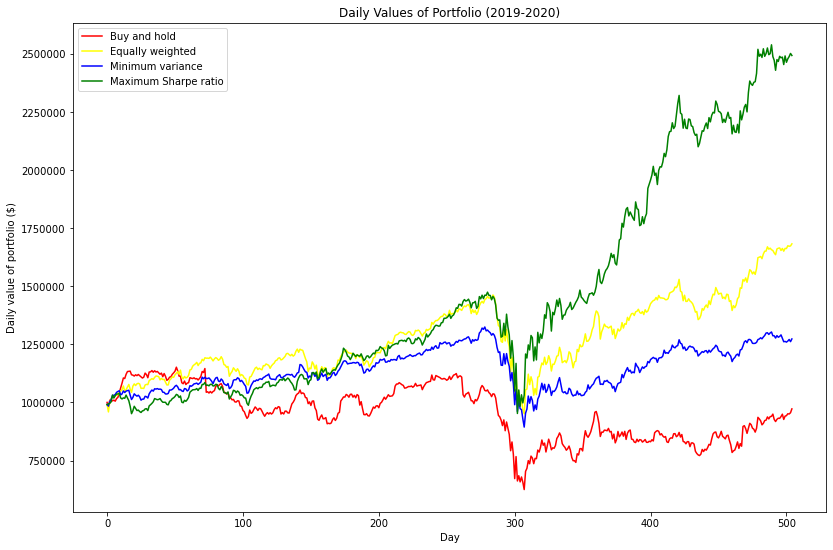

In [123]:
# Daily values of portfolio plot

plt.figure(figsize=(13.5,9))
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_scientific(False)

plt.plot(portf_value[0], label='Buy and hold', color='red')
plt.plot(portf_value[1], label='Equally weighted', color='yellow')
plt.plot(portf_value[2], label='Minimum variance', color='blue')
plt.plot(portf_value[3], label='Maximum Sharpe ratio', color='green')

plt.legend()
plt.title('Daily Values of Portfolio (2019-2020)')
plt.xlabel('Day')
plt.ylabel('Daily value of portfolio ($)')

plt.show()

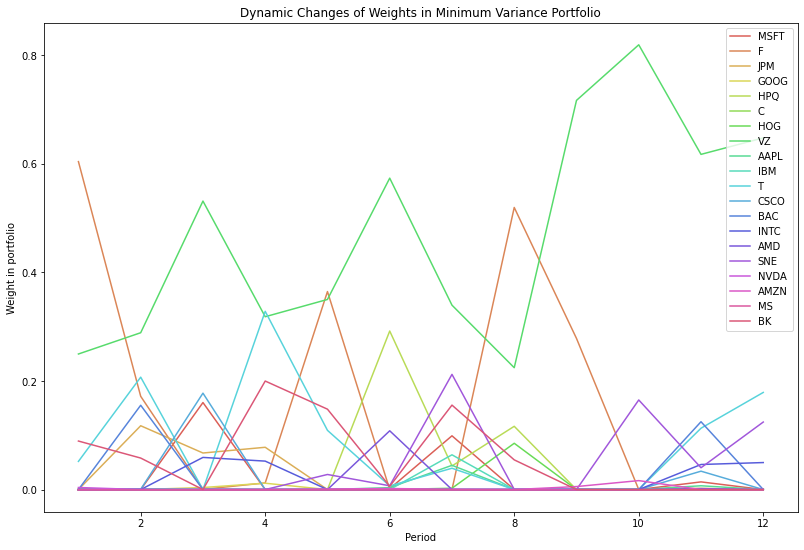

In [127]:
# Dynamic Changes of Weights in Minimum Variance Portfolio plot

stocks = df.columns[1:]
w = []

for period in range(1, N_periods+1):
    w.append(x[2, period-1]/sum(x[2, period-1]))
    
df2 = pd.DataFrame(np.array(w), columns=stocks, index=[1,2,3,4,5,6,7,8,9,10,11,12])
df2.plot(figsize=(13.5,9))
plt.title('Dynamic Changes of Weights in Minimum Variance Portfolio')
plt.xlabel('Period')
plt.ylabel('Weight in portfolio')
plt.show()

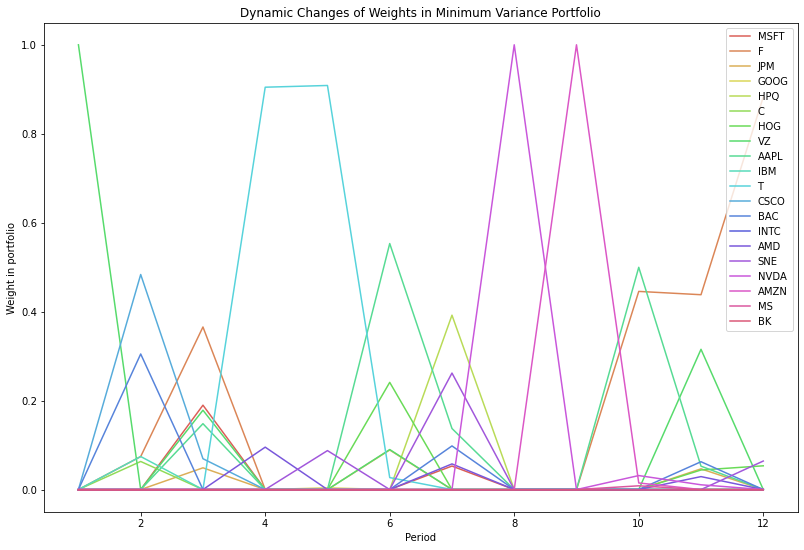

In [128]:
# Dynamic Changes of Weights in maximum Sharpe ratio plot

stocks = df.columns[1:]
w = []

for period in range(1, N_periods+1):
    w.append(x[3, period-1]/sum(x[3, period-1]))
    
df2 = pd.DataFrame(np.array(w), columns=stocks, index=[1,2,3,4,5,6,7,8,9,10,11,12])
df2.plot(figsize=(13.5,9))
plt.title('Dynamic Changes of Weights in Minimum Variance Portfolio')
plt.xlabel('Period')
plt.ylabel('Weight in portfolio')
plt.show()